# Implémentation de l'architecture des réseaux de neurones

*http://exo7.emath.fr/cours/livre-deepmath.pdf* 

## Chargement des modules et données

In [118]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

from sklearn import preprocessing, model_selection

In [119]:
df = pd.read_csv('market_data_pd.csv',sep=';')

In [120]:
df.head()

,Unnamed: 0,Reference Security,Ticker_x,Bid Price,Ask Price,Mid Price,Issuer Name,Cpn,Maturity,Ticker_y,...,Tot Debt / Tot Capital,Tot Loans to Tot Assets,Tot Risk-Based Cap,Earnings Assets / Int Bear Liab,Total Expenses to Average Earning Assets,PD_1y,BCLASS Level 1,BCLASS Level 2,BCLASS Level 3,BCLASS Level 4
0,0,AU053739 Corp,AABHFH,100.086,100.098,100.0920,Alandsbanken Abp,0.50,09/13/2021,AABHFH,...,87.2526,72.7382,275.5,NaN,NaN,0.053266,Corporate,Financial Institutions,Banking,Banking
1,1,BP432479 Corp,AAFFP,101.450,102.108,101.7790,Afflelou SAS,4.25,05/19/2026,AAFFP,...,77.8533,NaN,NaN,NaN,NaN,0.068537,Corporate,Industrial,Consumer Cyclical,Retailers
2,2,BP486833 Corp,AAFFP,101.375,102.375,101.8750,Afflelou SAS,8.00,05/19/2027,AAFFP,...,77.8533,NaN,NaN,NaN,NaN,0.119209,Corporate,Industrial,Consumer Cyclical,Retailers
3,3,EJ102177 Corp,AALLN,102.360,102.801,102.5805,Anglo American Capital PLC,3.50,03/28/2022,AALLN,...,80.4119,NaN,NaN,NaN,NaN,0.030968,Corporate,Industrial,Basic Industry,Metals and Mining
4,4,EK150567 Corp,AALLN,105.728,105.887,105.8075,Anglo American Capital PLC,3.25,04/03/2023,AALLN,...,80.4119,NaN,NaN,NaN,NaN,0.016911,Corporate,Industrial,Basic Industry,Metals and Mining


In [121]:
df.dtypes

Unnamed: 0                                    int64
Reference Security                           object
Ticker_x                                     object
Bid Price                                   float64
Ask Price                                   float64
Mid Price                                   float64
Issuer Name                                  object
Cpn                                         float64
Maturity                                     object
Ticker_y                                     object
Average Equity / Average Assets             float64
Common Eqty / Tot Assets                    float64
Debt / Common Equity                        float64
Debt/Assets                                 float64
Debt/EBITDA                                 float64
EBITDA                                      float64
Int Exp / Avg Int Bear Liab                 float64
Tot Debt / Tot Capital                      float64
Tot Loans to Tot Assets                     float64
Tot Risk-Bas

In [122]:
#mettre les ratios financiers
df1 = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"PD_1y"]]
#df1.replace(np.nan, 0.0,inplace=True)

In [128]:
df1 = df1.dropna(how = 'any') 
df1.head()
#on peut pas faire tourner l'algo avec des valeurs manquantes. Voir techniques pour les remplacer.

,Common Eqty / Tot Assets,Debt / Common Equity,BCLASS Level 3,PD_1y
0,4.84431,684.499,Banking,0.053266
1,17.15800,351.535,Consumer Cyclical,0.068537
2,17.15800,351.535,Consumer Cyclical,0.119209
3,19.24570,410.513,Basic Industry,0.030968
4,19.24570,410.513,Basic Industry,0.016911


In [124]:
df1.shape

(541, 4)

# Traitement des données

In [125]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])



In [139]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level 3']
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]


def traitement(X):
    
    ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False)
    
    std_scaler = preprocessing.StandardScaler().fit(X[:,continuous_features_idx])
    X_continuous_scaled = std_scaler.transform(X[:,continuous_features_idx])
    
    X_processed = np.hstack((ohe.fit_transform(X[:,discrete_features_idx]), X_continuous_scaled))
    
    return X_processed



In [140]:
X_processed = traitement(X_full)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_processed, y_full, test_size=0.20,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

In [59]:
#Préparation bases de train et de test 

#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(df1.drop("PD_1y",axis=1),df1["PD_1y"],test_size=0.2, random_state=42)

**Variables quanti : standardisation**

In [60]:
num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]

In [61]:
#Standardisation des données 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True,with_std=True)
scaler.fit(X_train[num_cols])
    

x_train = X_train
x_train[num_cols] = scaler.transform(X_train[num_cols])
x_train = pd.DataFrame(x_train, index=X_train.index, columns=X_train.columns)

x_test = X_test
x_test[num_cols] = scaler.transform(X_test[num_cols])
x_test = pd.DataFrame(x_test, index=X_test.index, columns=X_test.columns)

In [62]:
x_test

,Common Eqty / Tot Assets,Debt / Common Equity,BCLASS Level 3
258,-0.675572,-0.124417,Insurance
75,-0.980783,-0.079178,Banking
399,-0.815691,-0.124775,Insurance
88,-0.980783,-0.079178,Banking
527,-0.739888,-0.101769,Banking
...,...,...,...
160,0.852762,-0.122404,Consumer Cyclical
48,0.812190,-0.119765,Consumer Non-Cyclical
95,-0.980783,-0.079178,Banking
461,-0.707001,-0.085270,Transportation


In [13]:
x_train['Debt / Common Equity'].mean()

-2.133067385275185e-17

**Variables quali : binariser**

In [63]:
# BINARISER
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_test

,Common Eqty / Tot Assets,Debt / Common Equity,BCLASS Level 3_Banking,BCLASS Level 3_Basic Industry,BCLASS Level 3_Brokerage Assetmanagers Exchanges,BCLASS Level 3_Capital Goods,BCLASS Level 3_Consumer Cyclical,BCLASS Level 3_Consumer Non-Cyclical,BCLASS Level 3_Finance Companies,BCLASS Level 3_Government Owned. No Guarantee,BCLASS Level 3_Insurance,BCLASS Level 3_Local Authority,BCLASS Level 3_Mortgage Assets,BCLASS Level 3_Other Financial,BCLASS Level 3_REITs,BCLASS Level 3_Technology,BCLASS Level 3_Transportation
258,-0.675572,-0.124417,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
75,-0.980783,-0.079178,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
399,-0.815691,-0.124775,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
88,-0.980783,-0.079178,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
527,-0.739888,-0.101769,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.852762,-0.122404,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
48,0.812190,-0.119765,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
95,-0.980783,-0.079178,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
461,-0.707001,-0.085270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [64]:
x_train

,Common Eqty / Tot Assets,Debt / Common Equity,BCLASS Level 3_Banking,BCLASS Level 3_Basic Industry,BCLASS Level 3_Brokerage Assetmanagers Exchanges,BCLASS Level 3_Capital Goods,BCLASS Level 3_Communications,BCLASS Level 3_Consumer Cyclical,BCLASS Level 3_Consumer Non-Cyclical,BCLASS Level 3_Electric,...,BCLASS Level 3_Insurance,BCLASS Level 3_Local Authority,BCLASS Level 3_Mortgage Assets,BCLASS Level 3_Natural Gas,BCLASS Level 3_Other Financial,BCLASS Level 3_Other Industrial,BCLASS Level 3_REITs,BCLASS Level 3_Supranational,BCLASS Level 3_Technology,BCLASS Level 3_Transportation
275,0.942386,-0.119424,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
602,-0.020776,-0.106781,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
471,-0.596908,-0.116311,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,-0.636996,-0.078427,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
400,-0.815691,-0.124775,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-0.980783,-0.079178,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,0.166290,-0.115515,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
303,-1.140435,0.656753,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
490,-0.912937,-0.105228,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Réseaux de neurones 

In [12]:
#RESEAUX DE NEURONES 
#http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Packages_Python_for_Deep_Learning.pdf

#Explications très bien dans ce document : 

#http://exo7.emath.fr/cours/livre-deepmath.pdf 

#très bon document (parties Python, keras avec les codes et explications)

In [143]:
modele = Sequential()
modele.add(Dense(units=7,input_dim=23,activation="sigmoid")) #6 is good
modele.add(Dense(units=1,activation="sigmoid"))
#modele.add(Dropout(0.3))
learning_rate = 0.10

sgd = SGD(learning_rate)

#dim première couche = nombre de variables du df 

J'ai pris la fonction sigmoïde car elle est continue et à valeurs dans [0,1] (comme les probabilités de défaut). Régression logit. 

In [144]:
modele.compile(loss='mean_squared_error',optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])

In [145]:
print(modele.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 7)                 168       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 8         
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/9
15/15 [==============================] - 0s 8ms/step - loss: 0.0916 - mean_squared_error: 0.0916 - val_loss: 0.0586 - val_mean_squared_error: 0.0586
Epoch 2/9
15/15 [==============================] - 0s 2ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 3/9
15/15 [==============================] - 0s 2ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 4/9
15/15 [==============================] - 0s 2ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 5/9
15/15 [==============================] - 0s 2ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 6/9
15/15 [==============================] - 0s 2ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 7/9
15/15 [=============================

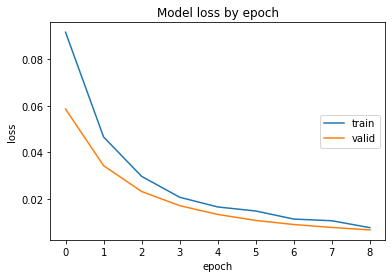

In [146]:
history = modele.fit(X_train, y_train,         # Train the model using the training set...
          batch_size=10, epochs=9,
          verbose=1, validation_split=0.35,steps_per_epoch=15)           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
#for loss_name, loss_value in list(zip(modele.metrics_names, modele.evaluate(x_test, y_test, verbose=1))):
 #   print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [150]:
X_test

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.11555492,  0.75603808],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.26459714, -0.11685016],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.84121934, -0.10839933],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.09158652, -0.10293429],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.89017757, -0.11079972],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.12373196, -0.10906185]])

In [ ]:
#Résultats 

resultat = modele.evaluate(x_test, y_test, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat[0])
print('Précision sur les données de test (MSE):', resultat[1])

## Observation des résultats 

In [151]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return abs(théo - préd) / théo

In [153]:
prediction = pd.DataFrame(data= modele.predict(X_test) ,columns=['Prédiction'])
théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])
prediction, théorique = prediction.reset_index() , théorique.reset_index()

results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)

In [154]:
results.head()

,Théorique,Prédiction,Ecart_relatif
0,0.015632,0.126909,7.118624
1,0.007943,0.093765,10.805042
2,0.016544,0.114846,5.941862
3,0.008842,0.116027,12.122554
4,0.014950,0.074640,3.992614


In [155]:
results["Ecart_relatif"].mean()

5.70987467549881

In [156]:
print("L'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")

L'écart relatif moyen est de 570.987467549881%


In [157]:
results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)

<AxesSubplot:xlabel='Théorique', ylabel='Prédiction'>

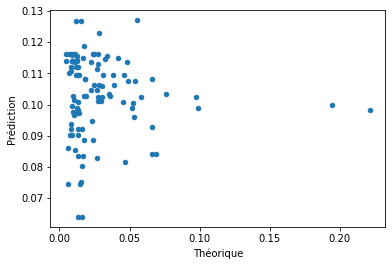

In [158]:
results.plot.scatter("Théorique","Prédiction")

---------------

In [159]:
df2 = df1.sort_values('PD_1y')

In [96]:
for idx, row in df2.iterrows():
    print('+==========')
    print(row)

+==========
Debt / Common Equity      4.343560e+02
Debt/Assets               2.628410e+01
Tot Debt / Tot Capital    7.945930e+01
PD_1y                     7.450581e-09
Name: 587, dtype: float64
+==========
Debt / Common Equity      0.000000e+00
Debt/Assets               0.000000e+00
Tot Debt / Tot Capital    0.000000e+00
PD_1y                     7.450581e-09
Name: 234, dtype: float64
+==========
Debt / Common Equity      48.288000
Debt/Assets                1.843050
Tot Debt / Tot Capital    32.435700
PD_1y                      0.015045
Name: 106, dtype: float64
+==========
Debt / Common Equity      43.05550
Debt/Assets                2.37374
Tot Debt / Tot Capital    28.90940
PD_1y                      0.01529
Name: 400, dtype: float64
+==========
Debt / Common Equity      36.374200
Debt/Assets                2.947590
Tot Debt / Tot Capital    23.741600
PD_1y                      0.016466
Name: 451, dtype: float64
+==========
Debt / Common Equity      144.896000
Debt/Assets          

Name: 504, dtype: float64
+==========
Debt / Common Equity      187.144000
Debt/Assets                37.753200
Tot Debt / Tot Capital     65.174300
PD_1y                       0.235446
Name: 8, dtype: float64
+==========
Debt / Common Equity      379.882000
Debt/Assets                46.426100
Tot Debt / Tot Capital     79.005500
PD_1y                       0.238657
Name: 503, dtype: float64
+==========
Debt / Common Equity      426.929000
Debt/Assets                70.866100
Tot Debt / Tot Capital     80.908200
PD_1y                       0.239543
Name: 229, dtype: float64
+==========
Debt / Common Equity      650.789000
Debt/Assets                31.257800
Tot Debt / Tot Capital     85.490000
PD_1y                       0.239969
Name: 57, dtype: float64
+==========
Debt / Common Equity      650.789000
Debt/Assets                31.257800
Tot Debt / Tot Capital     85.490000
PD_1y                       0.240107
Name: 58, dtype: float64
+==========
Debt / Common Equity      322.051000

In [65]:
arr = np.array([410.513,79.0061,80.4119]).reshape(-1,1) #ligne 1 et 2
scaler = StandardScaler(with_mean=True,with_std=True)
scaler.fit(arr)

x = scaler.transform(arr)

In [78]:
x = np.array([-0.079178,-0.424929,1.104960]).reshape(-1,1)

In [80]:
modele.predict(x.T)

array([[0.18508047]], dtype=float32)

In [68]:
y_test.head()

258    0.018366
75     0.351885
399    0.024631
88     0.128857
527    0.676359
Name: PD_1y, dtype: float64

In [67]:
x_test.head()

,Debt / Common Equity,Debt/Assets,Tot Debt / Tot Capital
258,-0.124417,-1.569320,-1.561454
75,-0.079178,-0.424929,1.104960
399,-0.124775,-1.635033,-1.730703
88,-0.079178,-0.424929,1.104960
527,-0.101769,-0.216428,0.865320
